In [3]:
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re

from torch import nn
import torch.nn.functional as F
import math

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# 1. Read and Parse Data
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

X_train = train_data['text'].values
y_train = train_data['label'].values

X_val = val_data['text'].values
y_val = val_data['label'].values

X_test = test_data['text'].values
y_test = test_data['label'].values

In [5]:
# 2. Tokenize Data
def tokenizer(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

def build_vocab(sentences):
    counter = Counter()
    for sentence in sentences:
        tokens = tokenizer(sentence)
        counter.update(tokens)
    vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.items())} 
    vocab["<pad>"] = 0
    vocab["<unk>"] = 1
    return vocab

vocab = build_vocab(X_train)

In [6]:
# 3. Preprocess Data
def text_pipeline(text, vocab):
    tokens = tokenizer(text)
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

label_vocab = {label: idx for idx, label in enumerate(set(y_train))}

def label_pipeline(label):
    label_index = label_vocab[label]
    one_hot = torch.zeros(4, dtype=torch.float)
    one_hot[label_index] = 1.0
    
    return one_hot

In [7]:
# 4. Prepare Data
X_train_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_train]
X_val_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_val]
X_test_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_test]

X_train_pad = pad_sequence(X_train_seq, batch_first=True, padding_value=vocab["<pad>"])
X_val_pad = pad_sequence(X_val_seq, batch_first=True, padding_value=vocab["<pad>"])
X_test_pad = pad_sequence(X_test_seq, batch_first=True, padding_value=vocab["<pad>"])

max_len = 32
X_train_pad = X_train_pad[:, :max_len]
X_val_pad = X_val_pad[:, :max_len]
X_test_pad = X_test_pad[:, :max_len]

X_train_pad = torch.cat([
    X_train_pad, 
    torch.full((X_train_pad.size(0), max_len - X_train_pad.size(1)), vocab["<pad>"])
], dim=1)

X_val_pad = torch.cat([
    X_val_pad, 
    torch.full((X_val_pad.size(0), max_len - X_val_pad.size(1)), vocab["<pad>"])
], dim=1)

X_test_pad = torch.cat([
    X_test_pad, 
    torch.full((X_test_pad.size(0), max_len - X_test_pad.size(1)), vocab["<pad>"])
], dim=1)

y_train_tensor = torch.stack([label_pipeline(label) for label in y_train])
y_val_tensor = torch.stack([label_pipeline(label) for label in y_val])
y_test_tensor = torch.stack([label_pipeline(label) for label in y_test])



In [8]:
# 5. Create DataLoader
train_dataset = TensorDataset(X_train_pad, y_train_tensor)
val_dataset = TensorDataset(X_val_pad, y_val_tensor)
test_dataset = TensorDataset(X_test_pad, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# 6. PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [10]:
# 7. Multi-head Attention
class MyMultiheadAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(MyMultiheadAttention, self).__init__()
        assert d_model % nhead == 0, "d_model must be divisible by nhead"
        
        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead
        
        # Linear layers for Q, K, V projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, attn_mask=None):
        batch_size = query.size(0)
        
        # Linear projections and reshape to (batch_size, nhead, seq_len, d_k)
        Q = self.W_q(query).view(batch_size, -1, self.nhead, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.nhead, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.nhead, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        # scores: (batch_size, nhead, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == 0, float('-inf'))
        
        # Apply softmax
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        # attn_output: (batch_size, nhead, seq_len, d_k)
        attn_output = torch.matmul(attn_weights, V)
        
        # Concatenate heads: (batch_size, seq_len, d_model)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # Final linear projection
        output = self.W_o(attn_output)
        
        return output, attn_weights

In [11]:
# 8. TransformerEncoderLayer
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(MyTransformerEncoderLayer, self).__init__()
        
        # Multi-head self-attention
        self.self_attn = MyMultiheadAttention(d_model, nhead, dropout=dropout)
        
        # Feed-forward network
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
    def forward(self, src, src_mask=None):
        # Self-attention with residual connection and layer norm
        attn_output, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        
        # Feed-forward network with residual connection and layer norm
        ff_output = self.linear2(self.dropout2(F.relu(self.linear1(src))))
        src = src + self.dropout3(ff_output)
        src = self.norm2(src)
        
        return src

In [12]:
# 9. TransformerClassifier
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        output_dim,
        pad_idx,
        nhead=8,
        num_layers=6,
    ):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=0.2,
            max_len=embedding_dim,  
        )
        
        self.encoder_layers = nn.ModuleList(
            [MyTransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dim_feedforward=64, dropout=0.2) 
             for _ in range(num_layers)]
        )

        self.linear_layer = nn.Linear(embedding_dim, 32)
        self.classifier = nn.Linear(32, output_dim)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float))  
        x = self.pos_encoder(x)
        
        for layer in self.encoder_layers:
            x = layer(x)

        x = x.mean(dim=1)
        
        x = self.linear_layer(x)
        x = torch.tanh(x)
        
        x = self.classifier(x)
        
        return x  

In [13]:
# 10. Define Hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
output_dim = len(label_vocab)
pad_idx = vocab["<pad>"]

In [21]:
# 11. Create Model
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=4,  
    num_layers=6 
)

In [22]:
print(model)

TransformerClassifier(
  (embedding): Embedding(15800, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x MyTransformerEncoderLayer(
      (self_attn): MyMultiheadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (linear1): Linear(in_features=128, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
      (dropout3): Dropo

In [23]:
# 12. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [24]:
# 13. Define Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []
        
        for batch in train_loader:
            X_batch, y_batch = batch
            
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            y_indices = y_batch.argmax(dim=1)  
            correct = (predicted == y_indices).sum().item()
            batch_acc.append(correct / y_batch.size(0))
        
        results['train_loss'].append(np.mean(batch_loss))
        results['train_acc'].append(np.mean(batch_acc))

        model.eval()
        total_correct = 0  
        total_samples = 0  
        val_batch_loss = []  
        
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_output = model(X_val_batch)
                val_loss = criterion(val_output, y_val_batch)
                val_batch_loss.append(val_loss.item())
                
                _, predicted = torch.max(val_output, 1)
                y_val_indices = y_val_batch.argmax(dim=1)
                total_correct += (predicted == y_val_indices).sum().item()
                total_samples += y_val_batch.size(0)

        results['val_loss'].append(np.mean(val_batch_loss))
        results['val_acc'].append(total_correct / total_samples)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {results['train_loss'][-1]:.4f}, "
              f"Train Acc: {results['train_acc'][-1]:.4f}, Val Loss: {results['val_loss'][-1]:.4f}, "
              f"Val Acc: {results['val_acc'][-1]:.4f}")
        
    return results

In [25]:
# 14. Train Model
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.3038, Train Acc: 0.3848, Val Loss: 1.2753, Val Acc: 0.3960
Epoch 2/100, Train Loss: 1.1230, Train Acc: 0.5315, Val Loss: 1.1400, Val Acc: 0.5000
Epoch 3/100, Train Loss: 0.9873, Train Acc: 0.6158, Val Loss: 1.0276, Val Acc: 0.5760
Epoch 4/100, Train Loss: 0.8730, Train Acc: 0.6581, Val Loss: 0.9296, Val Acc: 0.6120
Epoch 5/100, Train Loss: 0.7661, Train Acc: 0.7129, Val Loss: 0.9976, Val Acc: 0.6320
Epoch 6/100, Train Loss: 0.6922, Train Acc: 0.7471, Val Loss: 0.8785, Val Acc: 0.6520
Epoch 7/100, Train Loss: 0.6262, Train Acc: 0.7699, Val Loss: 0.8141, Val Acc: 0.6920
Epoch 8/100, Train Loss: 0.5514, Train Acc: 0.8017, Val Loss: 0.9390, Val Acc: 0.6520
Epoch 9/100, Train Loss: 0.5305, Train Acc: 0.8101, Val Loss: 0.9766, Val Acc: 0.6720
Epoch 10/100, Train Loss: 0.4725, Train Acc: 0.8363, Val Loss: 0.9332, Val Acc: 0.6680
Epoch 11/100, Train Loss: 0.4231, Train Acc: 0.8469, Val Loss: 0.8586, Val Acc: 0.7000
Epoch 12/100, Train Loss: 0.3894, Train Acc: 0.8648,

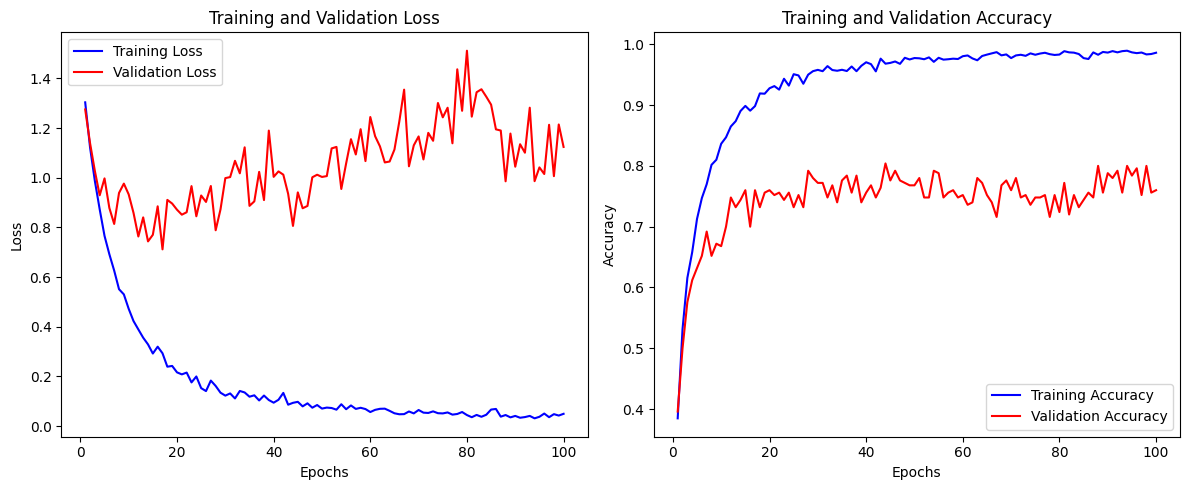

In [26]:
# 15. Plot result
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# 16. Evaluate Model

def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    test_batch_loss = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            test_output = model(X_test_batch)
            test_loss = criterion(test_output, y_test_batch)
            test_batch_loss.append(test_loss.item())

            _, predicted = torch.max(test_output, 1)
            y_test_indices = y_test_batch.argmax(dim=1)
            total_correct += (predicted == y_test_indices).sum().item()
            total_samples += y_test_batch.size(0)

    test_loss = np.mean(test_batch_loss)
    test_acc = total_correct / total_samples
    return test_loss, test_acc

test_loss, test_acc = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 1.1584, Test Acc: 0.7875


## (c) 

In [28]:
model1 = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=1,  
    num_layers=6 
)

history1 = train_model(model1, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.3922, Train Acc: 0.2436, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 2/100, Train Loss: 1.3926, Train Acc: 0.2533, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 3/100, Train Loss: 1.3927, Train Acc: 0.2529, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 4/100, Train Loss: 1.3921, Train Acc: 0.2488, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 5/100, Train Loss: 1.3926, Train Acc: 0.2461, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 6/100, Train Loss: 1.3921, Train Acc: 0.2627, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 7/100, Train Loss: 1.3922, Train Acc: 0.2584, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 8/100, Train Loss: 1.3921, Train Acc: 0.2511, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 9/100, Train Loss: 1.3931, Train Acc: 0.2520, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 10/100, Train Loss: 1.3929, Train Acc: 0.2511, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 11/100, Train Loss: 1.3916, Train Acc: 0.2570, Val Loss: 1.3874, Val Acc: 0.3200
Epoch 12/100, Train Loss: 1.3909, Train Acc: 0.2504,

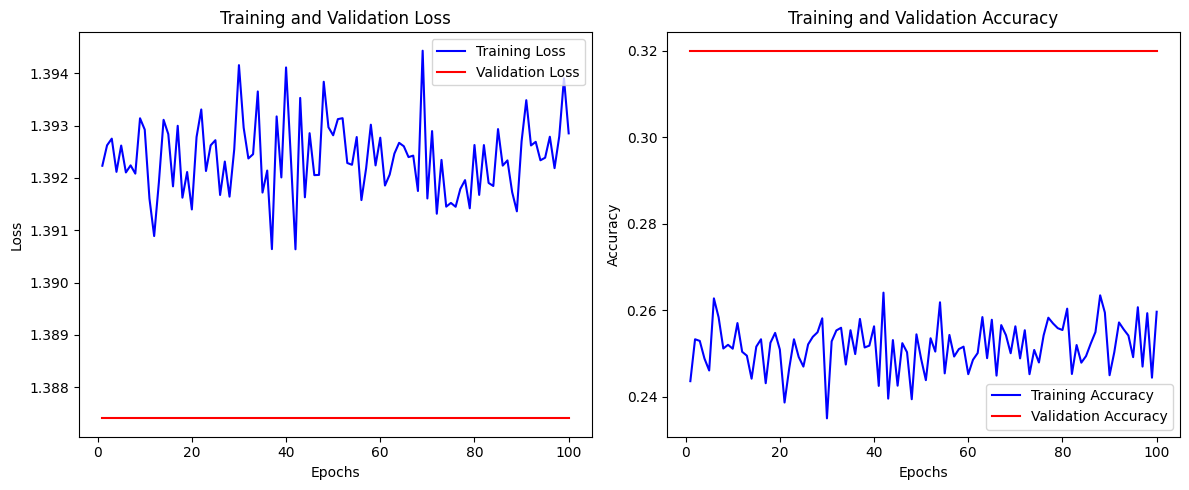

In [29]:
import matplotlib.pyplot as plt

epochs = range(1, len(history1['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history1['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history1['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history1['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history1['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
model8 = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=8,  
    num_layers=6 
)

history8 = train_model(model8, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.3858, Train Acc: 0.2679, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 2/100, Train Loss: 1.3870, Train Acc: 0.2634, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 3/100, Train Loss: 1.3880, Train Acc: 0.2569, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 4/100, Train Loss: 1.3856, Train Acc: 0.2614, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 5/100, Train Loss: 1.3856, Train Acc: 0.2538, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 6/100, Train Loss: 1.3870, Train Acc: 0.2672, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 7/100, Train Loss: 1.3858, Train Acc: 0.2628, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 8/100, Train Loss: 1.3862, Train Acc: 0.2663, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 9/100, Train Loss: 1.3869, Train Acc: 0.2623, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 10/100, Train Loss: 1.3865, Train Acc: 0.2665, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 11/100, Train Loss: 1.3863, Train Acc: 0.2706, Val Loss: 1.3976, Val Acc: 0.2040
Epoch 12/100, Train Loss: 1.3869, Train Acc: 0.2602,

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history8['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history8['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history8['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history8['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history8['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()